# Import Packages & Data

In [1]:
!pip install gdown
!pip install polars
!pip install gdown


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 27.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import os
import gdown
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import gc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.model_selection import RandomizedSearchCV

In [3]:
gdown.download(f"https://drive.google.com/uc?id=1gD8VdztzGjlQhfZIbFQZQb1Fk36wurtr", "Coursework Data.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1gD8VdztzGjlQhfZIbFQZQb1Fk36wurtr
From (redirected): https://drive.google.com/uc?id=1gD8VdztzGjlQhfZIbFQZQb1Fk36wurtr&confirm=t&uuid=6cd0287b-7a3e-42c6-9fdf-20517a882faf
To: /kaggle/working/Coursework Data.zip
100%|██████████| 1.79G/1.79G [00:22<00:00, 79.6MB/s]


'Coursework Data.zip'

In [4]:
!unzip "Coursework Data.zip"

Archive:  Coursework Data.zip
   creating: Coursework Data/
  inflating: Coursework Data/DemoStats.csv  
  inflating: Coursework Data/HouseholdSpend.csv  


In [5]:
demo_stats = pl.read_csv("Coursework Data/DemoStats.csv")
data = pl.read_csv("Coursework Data/HouseholdSpend.csv")
merged_data = data.join(demo_stats, on="CODE", how="inner")

# Basic Data Cleaning

In [6]:
# Since out target variable 
# =  Total personal insurance premiums and retirement/pension contributions / Household Income
# = (HSEP001S) /  (HSHNIAGG) 
# We need to make sure column "HSHNIAGG" does not have zero, so that Nan values wouldnt appear in out target variable
zero_income_count = merged_data.filter(pl.col("HSHNIAGG") == 0).height
if zero_income_count > 0:
    print("Warning: Zeros exist in the column: Household income", zero_income_count)
else : print("true")

In [7]:
# Replace the rows with Household_income == 0 to 1
merged_data = merged_data.with_columns(
    pl.when(pl.col("HSHNIAGG") == 0)
      .then(1)
      .otherwise(pl.col("HSHNIAGG"))
      .alias("HSHNIAGG")
)

In [8]:
# Create the TargetVariable
merged_data = merged_data.with_columns(
    (pl.col("HSEP001S") / pl.col("HSHNIAGG")).alias("TargetVariable")
)

In [9]:
columns_to_drop = ["HSEP001S", "HSHNIAGG",  "HSAGDISPIN", "HSAGDISCIN"]
merged_data = merged_data.drop(columns_to_drop)

numeric_types = {pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8}
allowed_non_numeric = {"CODE", "GEO", "GEO_right"}
non_numeric_cols = [col for col, dtype in merged_data.schema.items() if dtype not in numeric_types]

In [10]:
merged_data_numeric_columns = [col for col, dtype in zip(merged_data.columns, merged_data.dtypes) if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]

# Build expression list for z-scoring
z_score = [
    (pl.col(col_name) - pl.col(col_name).mean()) / pl.col(col_name).std()
    for col_name in merged_data_numeric_columns
]

# Replace those columns with their z-scored values
merged_data = merged_data.with_columns(z_score)

In [11]:
# The data is standardised
merged_data.head()

CODE,GEO,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,…,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P,TargetVariable
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""A0A0A0""","""FSALDU""",-0.265677,-0.26287,-0.272056,-0.263852,-0.271109,-0.284608,-0.265512,-0.264686,-0.254499,-0.26156,-0.252204,-0.268589,-0.277367,-0.283976,-0.299118,-0.248205,-0.266133,-0.272223,-0.261468,-0.236046,-0.164424,-0.197821,-0.118597,-0.125231,-0.293037,-0.251956,-0.284608,-0.295772,-0.305315,-0.305802,-0.305786,-0.258636,-0.184996,-0.263841,-0.146079,…,-0.045928,-0.106386,-0.061219,-0.011465,-0.061324,-0.054073,-0.037349,-0.267037,-0.211842,-0.357713,-0.330525,-0.324874,-0.302184,-0.282238,-0.283855,-0.22969,-0.267037,-0.211842,-0.357713,-0.31351,-0.333168,-0.340461,-0.355524,-0.285806,-0.22969,-0.267037,-0.35257,-0.302918,-0.184081,-0.267037,-0.247328,-0.223146,-0.251186,-0.299161,-0.266665,-0.29938,-2.151518
"""A0A1A0""","""FSALDU""",0.209965,0.020573,0.017895,-0.066404,0.044333,-0.096013,0.07348,0.078605,0.181493,0.0559,0.13678,-0.01019,-0.021501,-0.026361,-0.208289,0.150927,0.237157,0.168707,-0.008344,0.055503,0.03439,0.209723,0.005529,-0.016579,-0.299503,0.061753,-0.096013,-0.113514,-0.266516,-0.266425,-0.266139,-0.258021,-0.184735,-0.263066,-0.145612,…,-0.045928,-0.106386,-0.061219,-0.011465,-0.061324,-0.054073,-0.037349,0.053069,0.155508,-0.357713,-0.330525,-0.324874,-0.302184,-0.282238,-0.283855,-0.22969,0.053069,0.155508,-0.357713,-0.31351,-0.333168,-0.340461,-0.355524,-0.285806,-0.22969,0.053069,-0.35257,-0.302918,0.23316,0.053069,0.088312,-0.223146,0.170432,-0.299161,-0.266665,-0.29938,-0.359155
"""A0A1B0""","""FSALDU""",3.236776,2.031309,2.16423,1.366108,2.357128,1.683005,2.509056,2.526448,2.994301,2.158439,2.776198,1.878816,1.94842,2.092711,1.258742,2.141345,3.714686,2.568516,1.727596,1.392472,0.878065,2.079949,0.5339,0.23085,1.835684,2.300196,1.683005,1.738166,0.710375,0.711642,0.715105,0.179632,2.102939,0.232679,-0.055266,…,-0.045928,-0.106386,-0.061219,-0.011465,-0.061324,-0.054073,-0.037349,3.155189,3.64199,-0.023046,-0.120511,-0.05051,-0.302184,-0.282238,0.757496,-0.22969,3.155189,3.64199,-0.023046,-0.31351,-0.169575,-0.187806,-0.020084,0.730284,-0.22969,3.155189,-0.078839,0.266448,4.086953,3.155189,3.334864,3.025655,3.382394,-0.243276,-0.266665,-0.232804,0.525951
"""A0A1C0""","""FSALDU""",9.953414,9.212029,9.679005,8.657277,9.888204,7.980075,9.811939,10.452693,10.460299,10.309619,11.127167,8.914643,8.823232,9.462424,6.133766,9.382786,15.68113,9.079133,7.749527,5.771743,4.842732,8.26692,2.670438,2.677355,8.819832,10.183821,7.980075,8.066733,2.709135,2.735981,2.748105,0.834261,1.981438,0.63354,0.147067,…,-0.045928,-0.106386,13.925243,-0.011465,-0.061324,-0.054073,-0.037349,10.156785,11.416446,0.85926,1.139571,-0.05051,-0.302184,-0.282238,2.66664,0.724549,10.156785,11.416446,0.85926,0.862719,-0.005981,2.865296,0.449531,-0.031783,0.724549,10.156785,0.891662,0.99849,12.780745,10.156785,10.590785,10.702026,10.450245,0.539126,0.667602,0.499534,0.426596
"""A0A1E0""","""FSALDU""",2.271079,1.66964,1.751485,1.323246,1.860242,1.339631,1.925472,2.103525,2.329062,1.838093,2.21228,1.512824,1.547356,1.624577,0.7

In [12]:
merged_data.describe()

statistic,CODE,GEO,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,…,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P,TargetVariable
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,1.8230e-17,1.2314e-17,-3.8840e-17,3.3088e-17,-9.0722e-18,3.0831e-17,-1.6595e-17,1.8112e-18,2.1873e-17,2.2535e-17,-2.5197e-17,-2.0258e-17,-2.0843e-17,-1.6117e-17,7.4327e-17,2.3541e-17,-1.0368e-17,-2.4862e-17,2.5589e-17,1.1039e-18,-1.0466e-18,-6.9176e-18,5.6093e-18,-6.6723e-18,-6.0672e-18,-1.6517e-17,1.4314e-17,-7.6956e-17,5.0811e-17,3.6240e-17,-2.7401e-17,-2.4048e-17,-3.5304e-17,3.8431e-19,…,-1.3072e-17,-6.4673e-17,-1.7161e-18,-2.7691e-18,8.0757e-18,4.1773e-18,-3.6770e-18,-1.4285e-17,1.7175e-17,9.1826e-18,-4.8611e-17,-4.7050e-17,3.1211e-17,7.0092e-17,2.0238e-18,6.3056e-17,-1.4285e-17,1.7175e-17,9.1826e-18,1.4547e-17,3.3034e-17,5.0059e-17,1.0466e-17,-1.5238e-17,6.3056e-17,-1.4285e-17,-1.8602e-17,-1.5307e-17,3.7000e-18,-1.4285e-17,-3.6166e-17,1.4322e-17,-6.3493e-18,-1.3798e-17,6.0002e-17,2.6448e-17,6.6494e-17
"""std""",null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""min""","""A0A0A0""","""FSALDU""",-0.265677,-0.265525,-0.272056,-0.263852,-0.271109,-0.284608,-0.265512,-0.264686,-0.254499,-0.26156,-0.252204,-0.268589,-0.277367,-0.283976,-0.299118,-0.248205,-0.266133,-0.272223,-0.261468,-0.236046,-11.647398,-0.197821,-0.118597,-18.822428,-0.811111,-5.951546,-0.284608,-0.295772,-0.305315,-0.305802,-0.305786,-0.258636,-0.184996,-0.263841,…,-0.045928,-0.106386,-0.061219,-0.011465,-0.061324,-0.054073,-0.037349,-0.267037,-0.211842,-0.357713,-0.330525,-0.324874,-0.302184,-0.282238,-0.283855,-0.22969,-0.267037,-0.211842,-0.357713,-0.31351,-0.333168,-0.340461,-0.355524,-0.285806,-0.22969,-0.267037,-0.35257,-0.302918,-0.184081,-0.267037,-0.247328,-0.223146,-0.251186,-0.299161,-0.266665,-0.29938,-2.151518
"""25%""",null,null,-0.222436,-0.231227,-0.239094,-0.243087,-0.236095,-0.250961,-0.229905,-0.229724,

In [13]:
numeric_types = {pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8}
non_numeric_cols = [col for col, dtype in merged_data.schema.items() if dtype not in numeric_types]
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: ['CODE', 'GEO', 'GEO_right', 'ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED', 'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']


In [14]:
threshold = 3.0
exclude_cols = ['CODE', 'GEO', 'GEO_right', 'ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED', 'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']
columns_to_score = [col for col in merged_data.columns if col not in exclude_cols]
for col in columns_to_score:
    mean_val = merged_data.select(pl.col(col).mean()).item()
    std_val = merged_data.select(pl.col(col).std()).item()
    zscore_expr = (pl.col(col) - mean_val) / std_val
    outlier_count = merged_data.select(zscore_expr.abs().gt(threshold).sum().alias("outlier_count")).item()
    # print(f"Column '{col}' has {outlier_count} outlier rows (|z-score| > {threshold}).")

In [15]:
for col in columns_to_score:
  mean_val = merged_data.select(pl.col(col).mean()).item()
  std_val = merged_data.select(pl.col(col).std()).item()
  high_cap = mean_val + threshold * std_val
  low_cap = mean_val - threshold * std_val
  merged_data = merged_data.with_columns(pl.when(pl.col(col) > high_cap)
                                        .then(high_cap)
                                        .when(pl.col(col) < low_cap)
                                        .then(low_cap)
                                        .otherwise(pl.col(col))
                                        .alias(col)
                                        )

In [16]:
merged_data.describe()

statistic,CODE,GEO,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,…,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P,TargetVariable
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,-0.032487,-0.03005,-0.031037,-0.032447,-0.030834,-0.029993,-0.031219,-0.031156,-0.031232,-0.030848,-0.031005,-0.030787,-0.029596,-0.031118,-0.030245,-0.029586,-0.031856,-0.030777,-0.030955,-0.031399,-0.023566,-0.027852,-0.028029,-0.018688,-0.032676,-0.030309,-0.029993,-0.03036,-0.042611,-0.04266,-0.042625,-0.044701,-0.031203,-0.03589,…,-0.032854,-0.032738,-0.041178,-0.010741,-0.043328,-0.041143,-0.031722,-0.03161,-0.032232,-0.036962,-0.032221,-0.038203,-0.039853,-0.042603,-0.040061,-0.042994,-0.03161,-0.032232,-0.036962,-0.031803,-0.034845,-0.03451,-0.038461,-0.03976,-0.042994,-0.03161,-0.039171,-0.025757,-0.03269,-0.03161,-0.031509,-0.030255,-0.031638,-0.04263,-0.040361,-0.042623,-0.000153
"""std""",null,null,0.395038,0.386994,0.402843,0.424716,0.395997,0.419506,0.384869,0.388419,0.374634,0.39149,0.371489,0.396893,0.408718,0.41638,0.47548,0.373547,0.393016,0.41262,0.391381,0.398637,0.366426,0.313064,0.275007,0.416999,0.442394,0.369034,0.419506,0.435395,0.531092,0.531491,0.531417,0.515244,0.396418,0.504481,…,0.199131,0.450192,0.246879,0.046698,0.23402,0.198299,0.130618,0.376499,0.296013,0.601669,0.569489,0.621707,0.614519,0.556192,0.555257,0.514069,0.376499,0.296013,0.601669,0.580735,0.581619,0.602675,0.612934,0.589193,0.514069,0.376499,0.592566,0.467021,0.277359,0.376499,0.340637,0.331824,0.34493,0.555147,0.555667,0.549837,0.999485
"""min""","""A0A0A0""","""FSALDU""",-0.265677,-0.265525,-0.272056,-0.263852,-0.271109,-0.284608,-0.265512,-0.264686,-0.254499,-0.26156,-0.252204,-0.268589,-0.277367,-0.283976,-0.299118,-0.248205,-0.266133,-0.272223,-0.261468,-0.236046,-3.0,-0.197821,-0.118597,-3.0,-0.811111,-3.0,-0.284608,-0.295772,-0.305315,-0.305802,-0.305786,-0.258636,-0.184996,-0.263841,…,-0.045928,-0.106386,-0.061219,-0.011465,-0.061324,-0.054073,-0.037349,-0.267037,-0.211842,-0.357713,-0.330525,-0.324874,-0.302184,-0.282238,-0.283855,-0.22969,-0.267037,-0.211842,-0.357713,-0.31351,-0.333168,-0.340461,-0.355524,-0.285806,-0.22969,-0.2

# Fitting the Elastic Net Model

In [17]:
# (i). Target Varibale is created
# Followings are some extra data cleaning & Performance Enhancement
for col in merged_data.columns:
    dtype = merged_data.schema[col]
    if dtype == pl.Float64:
        merged_data = merged_data.with_columns(
            pl.col(col).cast(pl.Float32)
        )
    elif dtype == pl.Int64:
        merged_data = merged_data.with_columns(
            pl.col(col).cast(pl.Int32)
        )

gc.collect()

0

In [18]:
# (ii). Data Transform & Splitting
X = merged_data.drop(exclude_cols).drop(["ECYASQKM", "ECYALSQKM", "TargetVariable"])
y = merged_data.select("TargetVariable").to_series()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
param_grid = {
    "model__alpha": [0.01, 0.02, 0.3],
    "model__l1_ratio": [0.1, 0.15]
}

pipeline = Pipeline([
    ('model', ElasticNet(max_iter=10000))
])

In [20]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Best parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'model__alpha': 0.01, 'model__l1_ratio': 0.1}


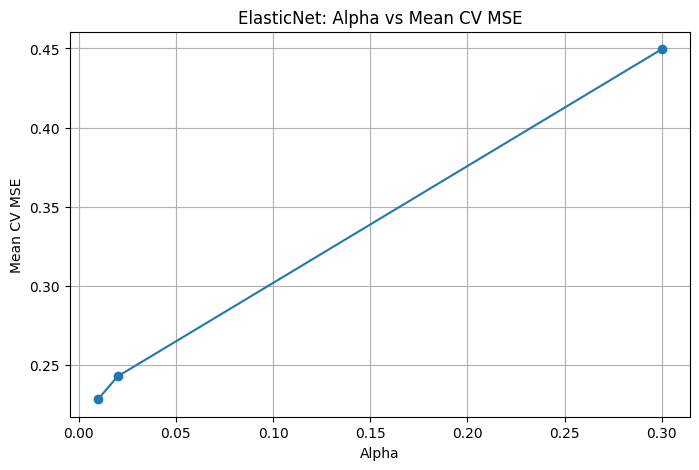

In [21]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Group by alpha
alpha_mse = results_df.groupby("param_model__alpha")["mean_test_score"].mean()

plt.figure(figsize=(8, 5))
plt.plot(alpha_mse.index, -alpha_mse.values, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Mean CV MSE")
plt.title("ElasticNet: Alpha vs Mean CV MSE")
plt.grid(True)
plt.show()

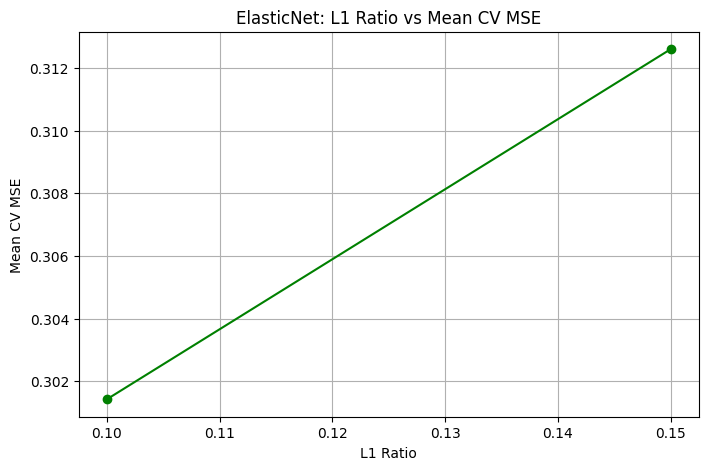

In [22]:
l1_mse = results_df.groupby("param_model__l1_ratio")["mean_test_score"].mean()

plt.figure(figsize=(8, 5))
plt.plot(l1_mse.index, -l1_mse.values, marker='o', color='green')
plt.xlabel("L1 Ratio")
plt.ylabel("Mean CV MSE")
plt.title("ElasticNet: L1 Ratio vs Mean CV MSE")
plt.grid(True)
plt.show()

In [23]:
EN = ElasticNet(alpha=0.01, l1_ratio=0.1)
EN.fit(X_train, y_train)
y_pred = EN.predict(X_test)
ENmse = mean_squared_error(y_test, y_pred)
ENr2 = r2_score(y_test, y_pred)
print(f"Test set MSE: {ENmse:.4f}")
print(f"Test set R2: {ENr2:.4f}")

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e+03, tolerance: 6.075e+01
  model = cd_fast.enet_coordinate_descent(


Test set MSE: 0.2276
Test set R2: 0.7722


In [24]:
nonzero_count = np.sum(EN.coef_ != 0)
print(f"Non-zero coefficients: {nonzero_count}")

Non-zero coefficients: 280


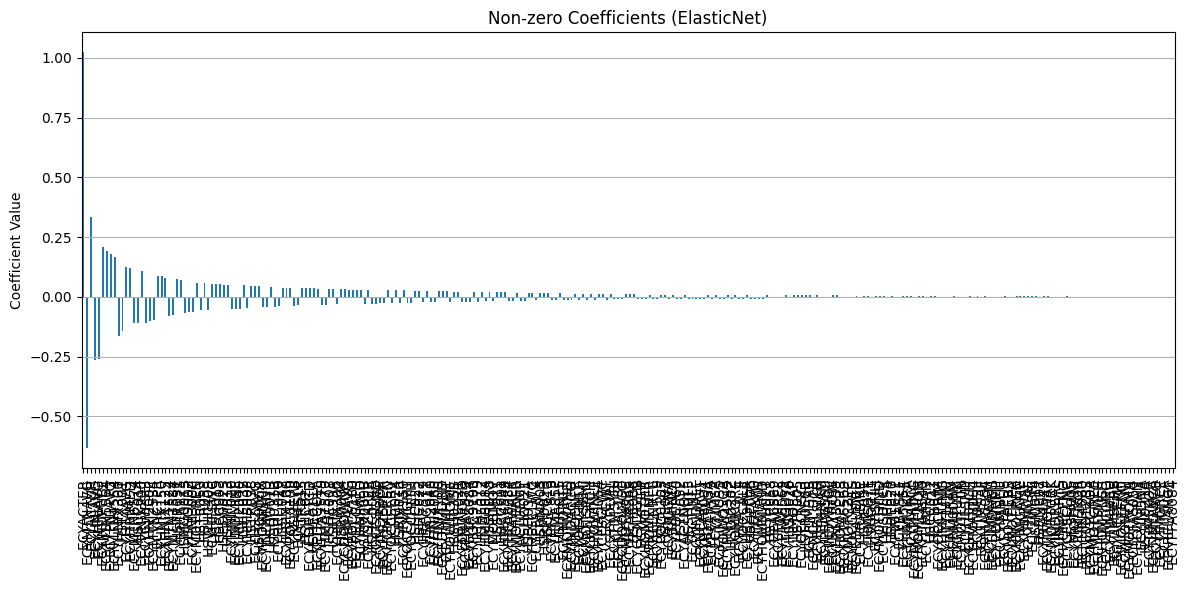

In [25]:
coef_series = pd.Series(EN.coef_, index=X_train.columns)
nonzero_coef = coef_series[coef_series != 0].sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 6))
nonzero_coef.plot(kind='bar')
plt.ylabel("Coefficient Value")
plt.title("Non-zero Coefficients (ElasticNet)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [26]:
# Create a pandas Series of coefficients with feature names
coef_series = pd.Series(EN.coef_, index=X_train.columns)

# Convert to a DataFrame
coef_df = coef_series.reset_index()
coef_df.columns = ["Feature", "Coefficient"]

# Add column for absolute magnitude (for sorting)
coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()

# Sort by absolute value
coef_df_sorted = coef_df.sort_values(by="AbsCoefficient", ascending=False).reset_index(drop=True)
nonzero_coef_df = coef_df_sorted[coef_df_sorted["Coefficient"] != 0]
nonzero_coef_df

,Feature,Coefficient,AbsCoefficient
0,ECYACTER,1.023902e+00,1.023902e+00
1,ECYMTNAVG,-6.327442e-01,6.327442e-01
2,ECYACTUR,3.346855e-01,3.346855e-01
3,ECYHNIAVG,-2.633783e-01,2.633783e-01
4,ECYHRIAVG,-2.609941e-01,2.609941e-01
...,...,...,...
275,ECYPTAAVG,8.066206e-05,8.066206e-05
276,ECYTIMGREE,-6.690929e-05,6.690929e-05
277,ECYTIMUSA,-5.786104e-05,5.786104e-05
278,ECYRELANGL,1.136079e-05,1.136079e-05


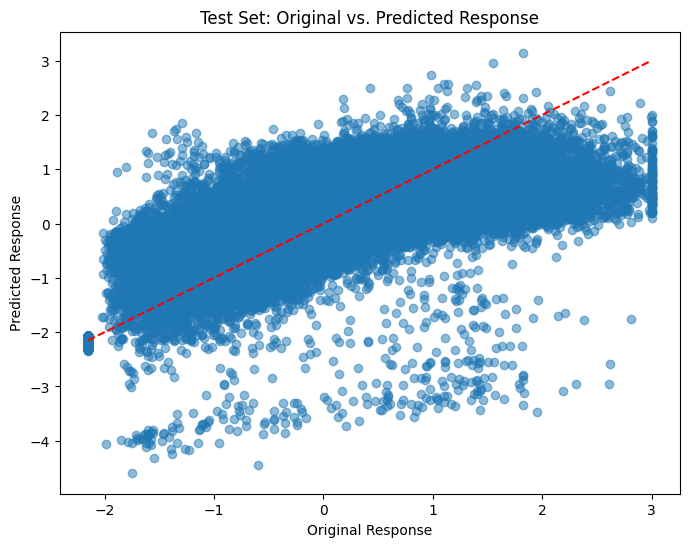

In [27]:
# Scatterplot: original response vs predicted response
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Original Response")
plt.ylabel("Predicted Response")
plt.title("Test Set: Original vs. Predicted Response")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.show()

In [28]:
# Bootstrapped confidence interval for the MSE
# Ensure y_test and y_pred are NumPy arrays
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

# Bootstrapped confidence interval for the MSE
n_bootstraps = 1000
bootstrapped_mses = []

for _ in range(n_bootstraps):
    indices = np.random.randint(0, len(y_test_np), len(y_test_np))
    y_test_boot = y_test_np[indices]
    y_pred_boot = y_pred_np[indices]
    boot_mse = mean_squared_error(y_test_boot, y_pred_boot)
    bootstrapped_mses.append(boot_mse)

# Calculate the 95% confidence interval
CI_lower_bound = np.percentile(bootstrapped_mses, 2.5)
CI_upper_bound = np.percentile(bootstrapped_mses, 97.5)

print(f"Bootstrapped 95% CI for MSE: [{CI_lower_bound:.4f}, {CI_upper_bound:.4f}]")

Bootstrapped 95% CI for MSE: [0.2253, 0.2301]


In [29]:
# -------------------------------
# (v) Interpret top five coefficients
# -------------------------------
# After the pipeline, the ElasticNet model is stored under 'model' in our pipeline.
# Retrieve the coefficient values and feature names.
coefs = best_model.named_steps['model'].coef_
feature_names = X.columns

# Create a dataframe for easier inspection.
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
# Compute absolute coefficients for ranking importance
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
top5 = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(5)
print("Top 5 most important variables and their coefficients:")
print(top5[['Feature', 'Coefficient']])

Top 5 most important variables and their coefficients:
       Feature  Coefficient
550   ECYACTER     1.025438
386  ECYMTNAVG    -0.632726
551   ECYACTUR     0.335265
519  ECYHNIAVG    -0.262960
503  ECYHRIAVG    -0.262861
